In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob
import time
import cv2

from skimage.feature import hog
from lesson_functions import *
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
path2test_images = "./test_images/"
pattern = "*jpg"

path2cars = "./vehicles/"
path2not_cars = "./non-vehicles/"
pattern_train = "*png"

In [3]:
test_images = glob.glob(path2test_images + pattern)
test_images

['./test_images/test2.jpg',
 './test_images/test1.jpg',
 './test_images/test5.jpg',
 './test_images/test6.jpg',
 './test_images/test3.jpg',
 './test_images/test4.jpg']

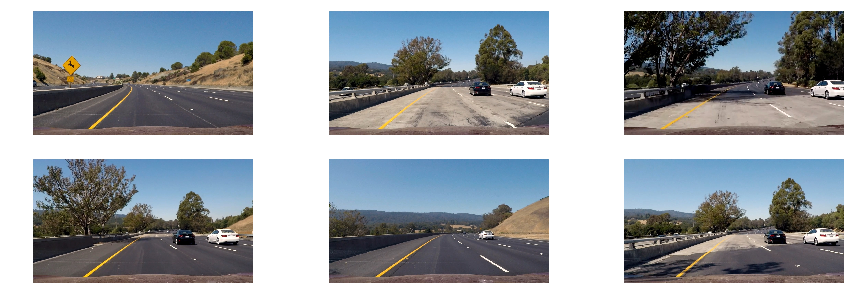

In [4]:
plt.figure(1, figsize=(15, 5))

i = 1

for image_name in test_images:
    img = cv2.imread(image_name)
    img = img[:,:, [2,1,0]]
    plt.subplot(2,3, i)
    plt.imshow(img)
    plt.axis('off')
    i += 1

Ok, these were the test images. Now is time to download the dataset for training

* Small dataset

    https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles_smallset.zip

    https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles_smallset.zip

* Full dataset

    https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip

    https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip

!wget https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip && unzip vehicles.zip

!wget https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip && unzip non-vehicles.zip

Note: the previous 2 cells were converted to Markdown cells to avoid accidental unwanted executions

What does the dataset look like?

In [5]:
cars = glob.glob(path2cars + "**/" + pattern_train, recursive=True)
notcars = glob.glob(path2not_cars + "**/" + pattern_train, recursive=True)

Your dataset contains a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: uint8


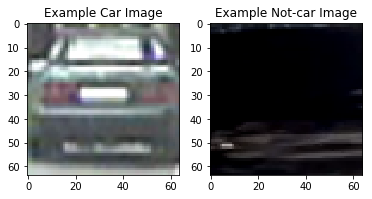

In [6]:
data_info = data_look(cars, notcars)

print('Your dataset contains a count of', data_info["n_cars"], ' cars and', data_info["n_not_cars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', data_info["data_type"])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(data_info['cars_sample'])
_ = plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(data_info['not_cars_sample'])
_ = plt.title('Example Not-car Image')

This are the steps we need to accomplish:
    
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier.
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the testvideo.mp4 and later implement on full projectvideo.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier.
### Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
### Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

In [7]:
# Parameters

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

# HOG
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

# Color
spatial_size = (32, 32)
hist_bins = 32

In [8]:
%%time

car_features = extract_features(cars, colorspace, spatial_size, hist_bins, \
                                orient,pix_per_cell, cell_per_block, hog_channel, \
                                spatial_feat=True, hist_feat=True, hog_feat=True)


notcar_features = extract_features(cars, colorspace, spatial_size, hist_bins, \
                                orient,pix_per_cell, cell_per_block, hog_channel, \
                                spatial_feat=True, hist_feat=True, hog_feat=True)

CPU times: user 37.1 s, sys: 1.18 s, total: 38.2 s
Wall time: 44.2 s


In [9]:
# Create an array stack of feature vectors
#X = np.vstack((car_features, notcar_features)).astype(np.float64)
X = np.vstack((car_features, notcar_features)).astype(np.float32)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4932


In [11]:
# Use a linear SVC 
svc = LinearSVC()

In [12]:
%%time
svc.fit(X_train, y_train)

CPU times: user 3min 11s, sys: 525 ms, total: 3min 11s
Wall time: 3min 11s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [13]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.3125
My SVC predicts:  [ 1.  0.  1.  0.  0.  1.  1.  0.  0.  1.]
For these 10 labels:  [ 1.  1.  0.  0.  1.  0.  0.  0.  1.  0.]
0.00158 Seconds to predict 10 labels with SVC
